[*********************100%***********************]  1 of 1 completed

Epoch 1/50



e:\Anaconda\envs\Bilal-2.0\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1207 - val_loss: 0.1843
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0051 - val_loss: 0.1867
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0025 - val_loss: 0.1798
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0024 - val_loss: 0.1892
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0027 - val_loss: 0.1757
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0017 - val_loss: 0.1767
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0015 - val_loss: 0.1702
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0021 - val_loss: 0.1476
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0013 - val_loss: 0.1421
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0019 - val_loss: 0.1249
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0014 - val_loss: 0.0861
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0021 - val_l

C:\Users\Dell\AppData\Local\Temp\ipykernel_9020\184035097.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


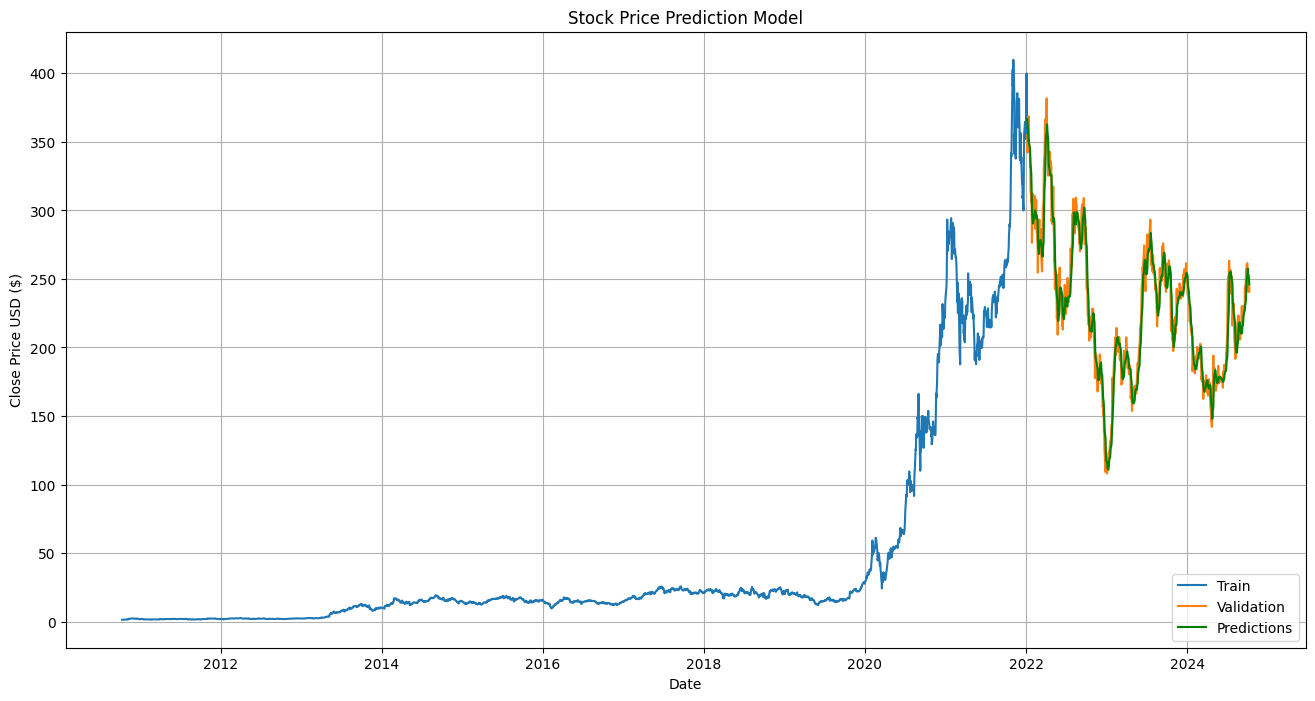

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import os

# Function to load data with error handling
def load_data(company, start_date, end_date):
    try:
        data = yf.download(company, start=start_date, end=end_date, interval='1d')
        if data.empty:
            raise ValueError(f"No data fetched for {company} within the given dates.")
        return data[['Close']]  
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Preprocessing data and handling sequence length flexibility
def preprocess_data(data, seq_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i, 0]) 
        y.append(scaled_data[i, 0])  
    
    X = np.array(X).reshape(-1, seq_length, 1) 
    y = np.array(y)
    
    return X, y, scaler

# Build model with BatchNormalization and modified architecture
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.3))  
    model.add(BatchNormalization()) 
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to plot results with improved visualization
def plot_results(train, valid, predictions, split):
    plt.figure(figsize=(16, 8))
    plt.title('Stock Price Prediction Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    
    plt.plot(train['Close'], label='Train')
    plt.plot(valid['Close'], label='Validation')
    
    # Add predictions and shaded regions for better visualization
    plt.plot(valid.index, predictions, label='Predictions', color='green')
    plt.fill_between(valid.index, valid['Close'], predictions.flatten(), color='lightgreen', alpha=0.3)
    
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Main function to execute the model
def main():
    company = 'TSLA'  # Tesla Inc.
    start_date = '2010-10-10'
    end_date = '2024-10-10'
    seq_length = 60  
    epochs = 50
    batch_size = 64
    train_split_ratio = 0.8 

    # Load and preprocess data
    data = load_data(company, start_date, end_date)
    if data is None:
        return 
    
    X, y, scaler = preprocess_data(data, seq_length)

    # Split data into training and testing sets
    split = int(train_split_ratio * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the model
    model = build_model((seq_length, 1)) 
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
    
    # Train the model with an explicit validation set
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), 
                        callbacks=[checkpoint, early_stop])
    
    # Save the training history for later analysis
    if not os.path.exists('model_logs'):
        os.makedirs('model_logs')
    pd.DataFrame(history.history).to_csv('model_logs/training_history.csv', index=False)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions and y_test to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

    # Calculate RMSE using the rescaled y_test
    rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions))
    print(f'RMSE: {rmse}')

    # Prepare data for plotting
    train = data[:split + seq_length]
    valid = data[split + seq_length:]
    valid['Predictions'] = predictions

    # Plot results with improved visualization
    plot_results(train, valid, predictions, split)

# Execute the main function
if __name__ == "__main__":
    main()
